# Final: saving all HMM data, of which the states timecourses.

## The libraries and methods we need:

In [1]:
import numpy as np
from loader import load_oneIC

In [2]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
import h5py

In [5]:
import xarray as xr

In [6]:
directory = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

## Functions:

### Cumputing functions:
I added an argument, `random_state`, which is an int representing the seed of the random number generator.

In [7]:
# The embedx function copies the `x` array len(lags) times into `xe`
# with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# The hmm_tde function finds parameters for the HMM,
# then uses them to determine the probability of presence of each found state over time.

def hmm_tde(y: np.array, lags, subj, IC, n_lags, n_states=3, n_iter=100, n_components=8, 
            covariance_type='full', model_type='GMMHMM', tol=0.01, random_state=1, n_mix=1, **kwargs):
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, random_state=random_state, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)

    return gamma, model

## The routine:

#### Model and parameters:
|_ 58delays x (7s x 256Hz x 10trials)   -----PCA-----> |_ 40components x (7s x 256Hz x 10trials) -----> |_ TDE-HMM
                                                                                                        (
                                                                                                        1 Gaussian/state,
                                                                                                        3 states
                                                                                                        )

In [8]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_lags = lags.shape[0]
n_iter=100
n_states=3    # for the Hidden Markov Model
n_components=40     # For the principal component analysis
covariance_type='diag'
model_type='GMMHMM'
tol=0.01
n_mix=1

##### Tests for a run on all ICs

In [24]:
subj = 2

# Loading all data for subject{subj}, IC{IC}
datall = []
for IC in range(1, n_IC+1):
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
    x = big_timecourse.reshape(-1, 1)
    xe, valid = embedx(x, lags)
    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])
    datall.append(y)
# ds = xr.open_dataset(origin_dir+f"/su{subj}-3states_data.nc")

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


In [ ]:
seed=1

In [27]:
y = np.concatenate(datall, axis=1)
gamma, model = hmm_tde(y, lags, subj, IC, n_lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                           covariance_type=covariance_type, model_type=model_type, tol=tol, random_state=seed, n_mix=n_mix)


(1210218, 160)

In [9]:
subj = 2

# Loading all data for subject{subj}, IC{IC}
datall = []
for IC in range(1, n_IC+1):
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
    x = big_timecourse.reshape(-1, 1)
    xe, valid = embedx(x, lags)
    datall.append(xe)
# ds = xr.open_dataset(origin_dir+f"/su{subj}-3states_data.nc")

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


In [10]:
xe = np.concatenate(datall, axis=2)
xe.shape

(1, 1210218, 232)

In [12]:
pca = PCA(n_components=n_components)
y = pca.fit_transform(xe[0, :, :])


In [13]:
y.shape

(1210218, 40)

In [ ]:
seed=1

In [14]:
gamma, model = hmm_tde(y, lags, subj, IC, n_lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                           covariance_type=covariance_type, model_type=model_type, tol=tol, random_state=seed, n_mix=n_mix)

##### Here is the `show_bigstates` function 

In [9]:
def show_bigstates(
    gamma, n_states, xe, # the data we need for the plot
    
    subj, IC, # which IC of which subject is of interest here
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
):

    fig = plt.figure(figsize=(6, 6))
    plt.title('State Power Spectrum')
    max_power = np.zeros(n_states)
    psd_all = np.zeros((n_states, 196))
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        
        max_power[i] = np.amax(psd[80:])
        
        psd_all[i] = psd[:196]
        plt.plot(freqs[:196], psd_all[i])
    
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
    plt.tight_layout()   

    plt.savefig(f'tde-hmm2/png_files/test{ts}su{subj}IC{IC}All_lg{n_lags}co{n_components}st{n_states}'
                    +f'{n_mix}'+model_type+'_states-info.png', dpi=600)
    
    plt.close(fig)
    
    return psd_all, freqs[:196], max_power

(array([[0.00477107, 0.01115938, 0.01525541, 0.02001059, 0.02356244,
         0.0249034 , 0.02413552, 0.02208548, 0.01969014, 0.01757487,
         0.01597036, 0.01484768, 0.01408261, 0.01355042, 0.01315474,
         0.01282893, 0.01253179, 0.01224061, 0.01194228, 0.01162649,
         0.01128363, 0.01090635, 0.01049216, 0.01004503, 0.00957496,
         0.00909607, 0.00862469, 0.00817881, 0.00777755, 0.00743796,
         0.00716896, 0.00696675, 0.00681699, 0.00670425, 0.00662255,
         0.00657883, 0.00658623, 0.00665216, 0.00676922, 0.00691416,
         0.00705367, 0.00715212, 0.00717775, 0.00710691, 0.00692808,
         0.0066458 , 0.00628216, 0.00587288, 0.00545774, 0.0050691 ,
         0.00472411, 0.00442445, 0.00416239, 0.00392868, 0.00371747,
         0.00352666, 0.00335568, 0.00320338, 0.0030675 , 0.00294533,
         0.00283414, 0.00273126, 0.00263421, 0.00254127, 0.00245234,
         0.00236913, 0.00229416, 0.00222911, 0.00217363, 0.00212546,
         0.00208168, 0.00204014, 0

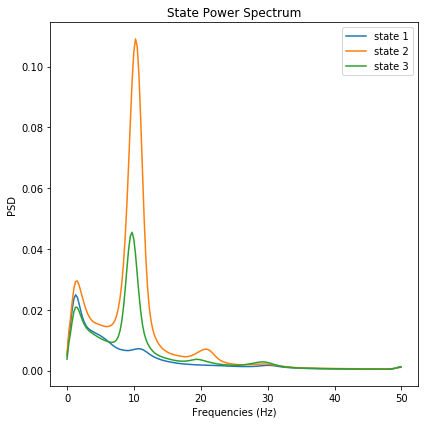

In [18]:
show_bigstates(
    gamma, n_states, xe, # the data we need for the plot
    
    subj, IC, # which IC of which subject is of interest here
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
)

##### Load 1 IC, then test 3 times the score of 3 models seeded differently

In [13]:
subj = 2
IC = 1

In [11]:
# random_state (RandomState or an int seed, optional) – A random number generator instance.       !!!!!!!!

# Loading all data for subject{subj}, IC{IC}
data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
x = big_timecourse.reshape(-1, 1)
xe, valid = embedx(x, lags)
pca = PCA(n_components=n_components)
y = pca.fit_transform(xe[0, :, :])
# ds = xr.open_dataset(origin_dir+f"/su{subj}-3states_data.nc")

Loading the raw timecourse


In [14]:
for ts in range(3):
    gamma, model = hmm_tde(
        y, lags, subj, IC, n_lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
        covariance_type=covariance_type, model_type=model_type, tol=tol, random_state=(ts+3), n_mix=n_mix
    )
    psd, freqs, max_power = show_bigstates(
        gamma, n_states, xe, # the data we need for the plot
        subj, IC, # which IC of which subject is of interest here
        n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    )
    print(f"test {ts}:", model.score(y))

test 0: -14374697.38177485
test 1: -14374697.381786052


KeyboardInterrupt: 

In [ ]:
subj = 11
IC = 3

# Loading all data for subject{subj}, IC{IC}
data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i] for i in range(n_trials)])
x = big_timecourse.reshape(-1, 1)
xe, valid = embedx(x, lags)
pca = PCA(n_components=n_components)
y = pca.fit_transform(xe[0, :, :])
# ds = xr.open_dataset(origin_dir+f"/su{subj}-3states_data.nc")

In [ ]:
for ts in range(4):
    gamma, model = hmm_tde(
        y, lags, subj, IC, n_lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
        covariance_type=covariance_type, model_type=model_type, tol=tol, n_mix=n_mix
    )
    psd, freqs, max_power = show_bigstates(
        gamma, n_states, xe, # the data we need for the plot
        subj, IC, # which IC of which subject is of interest here
        n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    )
    print(f"test {ts}:", model.score(y))